![.](preprocessing.jpg)

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
data = pd.read_excel("covid_dataset.xlsx") # `$ conda install openpyxl` is needed
data.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rappel

In [70]:
a = np.round(np.random.random((4,8)))
a[1,1] = a[1,2] = a[1,5] = a[2,4] = a[3,6] = a[0,7] = np.nan
a=pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
1,1.0,NaN,NaN,1.0,0.0,NaN,1.0,0.0
2,1.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0


In [71]:
a.dropna(axis=1)

,0,3
0,1.0,1.0
1,1.0,1.0
2,1.0,0.0
3,0.0,0.0


In [72]:
a.mean(axis=1)

0    0.857143
1    0.600000
2    0.428571
3    0.285714
dtype: float64

# Pre-processing de BASE :

In [73]:
df = data.copy()

missing_rate = df.isna().sum()/df.shape[0]

blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

df = df[key_columns + blood_columns + viral_columns]

## TrainTest

In [74]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [75]:
trainset['SARS-Cov-2 exam result'].value_counts(normalize=True)

negative    0.900997
positive    0.099003
Name: SARS-Cov-2 exam result, dtype: float64

In [76]:
trainset['SARS-Cov-2 exam result'].value_counts(normalize=True)

negative    0.900997
positive    0.099003
Name: SARS-Cov-2 exam result, dtype: float64

## Encodage

In [77]:
def encodage(df:pd.DataFrame):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes("object") :
        df[col] = df[col].map(code)
        
    return df

## Nettoyage

In [78]:
def imputation(df):
    return df.dropna(axis=0)

## preprocessing

In [79]:
def preprocessing(df:pd.DataFrame):
    
    df = encodage(df)
    df = imputation(df)

    X = df.drop("SARS-Cov-2 exam result", axis=1)
    y = df["SARS-Cov-2 exam result"]
    
    print(y.value_counts())
    
    return X, y

In [80]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


## Modelisation

In [81]:
from sklearn.tree import DecisionTreeClassifier
model_1 = DecisionTreeClassifier(random_state=0)

## Evaluation 

In [82]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [83]:
def evaluation(model, df, plot=True):
    
    trainset, testset = train_test_split(df, test_size=0.2, random_state=0)
    
    X_train, y_train = preprocessing(trainset)
    X_test, y_test = preprocessing(testset)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
          
    N, train_score, val_score = learning_curve(model, X_train, y_train,cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    if plot :
        plt.figure(figsize=(12, 8))
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.legend()
    
    return df, X_train

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64
0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64
[[52  2]
 [10  2]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        54
           1       0.50      0.17      0.25        12

    accuracy                           0.82        66
   macro avg       0.67      0.56      0.57        66
weighted avg       0.78      0.82      0.78        66



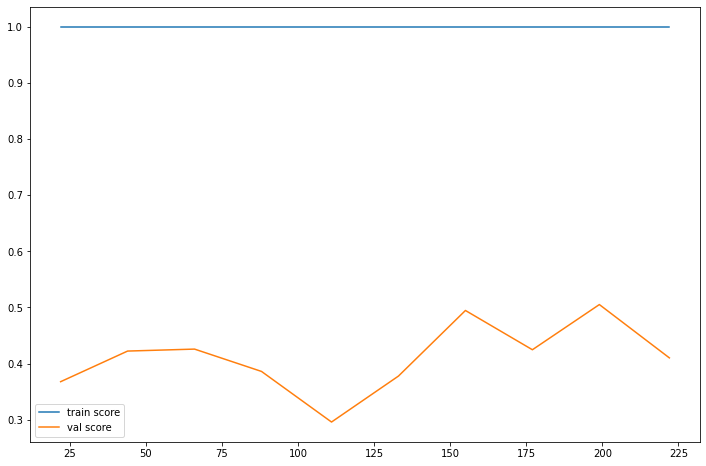

In [84]:
df, X_train = evaluation(model_1, df)

<AxesSubplot:>

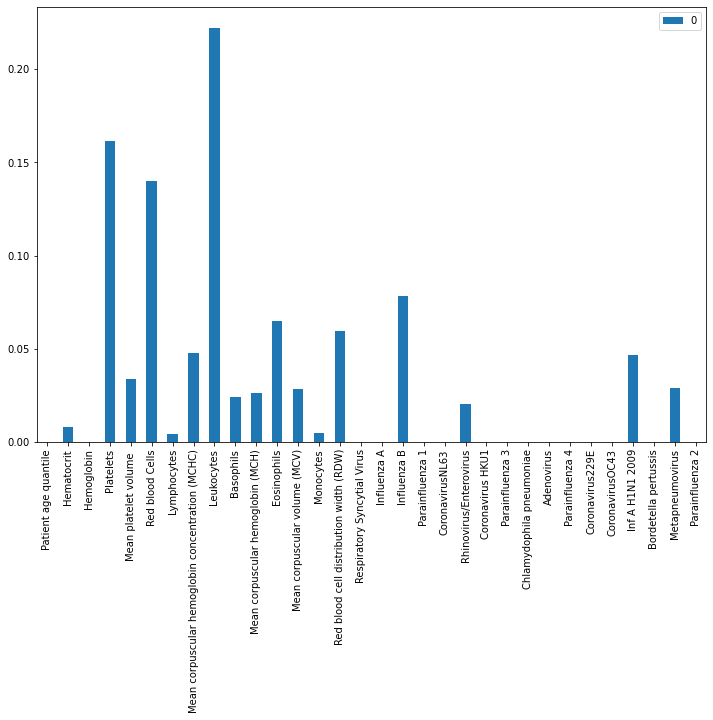

In [85]:
pd.DataFrame(model_1.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))

## On observe que les données sur les virus ne sont pas tres importante, on garde celle sur le sang

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

    accuracy                           0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111



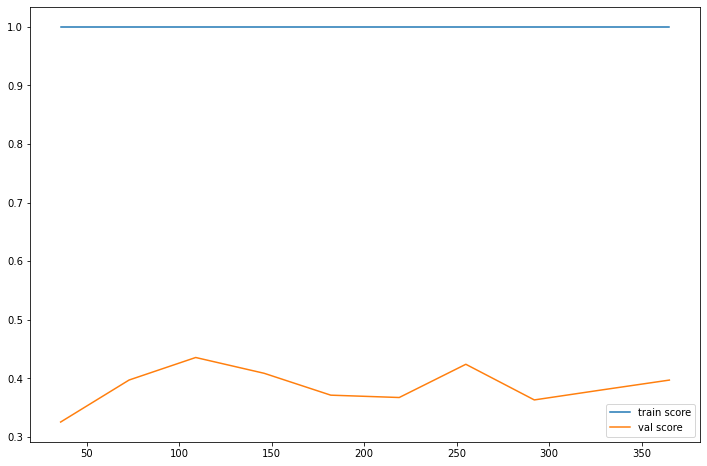

In [86]:
df_2 = data.copy()
df_2 = df_2[key_columns + blood_columns]

model_2 = DecisionTreeClassifier(random_state=0)
df_2, X_train_2 = evaluation(model_2, df_2)

## Lutter contre l'overfitting avec `RandomForestClassifier`

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[94  1]
 [14  2]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        95
           1       0.67      0.12      0.21        16

    accuracy                           0.86       111
   macro avg       0.77      0.56      0.57       111
weighted avg       0.84      0.86      0.82       111



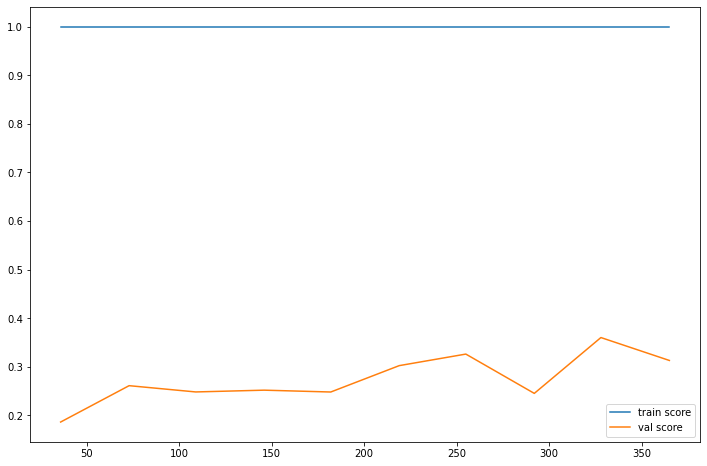

In [87]:
df_3 = data.copy()
df_3 = df_3[key_columns + blood_columns]

from sklearn.ensemble import RandomForestClassifier
model_3 = RandomForestClassifier(random_state=0)
df_3, X_train_3 = evaluation(model_3, df_3)

<AxesSubplot:>

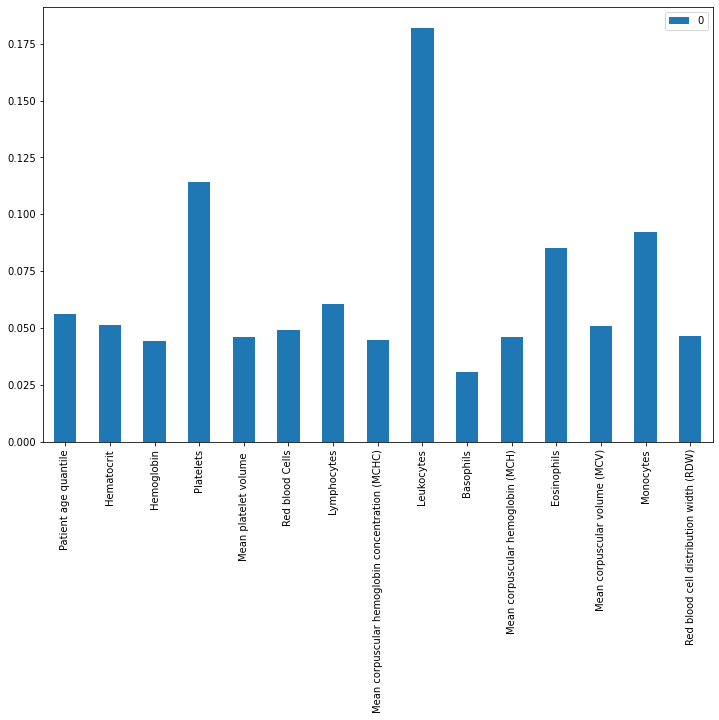

In [88]:
pd.DataFrame(model_3.feature_importances_, index=X_train_3.columns).plot.bar(figsize=(12, 8))

## Feature_engineering

In [89]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [90]:
def preprocessing(df:pd.DataFrame):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)

    X = df.drop("SARS-Cov-2 exam result", axis=1)
    y = df["SARS-Cov-2 exam result"]
    
    print(y.value_counts())
    
    return X, y

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[92  3]
 [13  3]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.50      0.19      0.27        16

    accuracy                           0.86       111
   macro avg       0.69      0.58      0.60       111
weighted avg       0.82      0.86      0.83       111



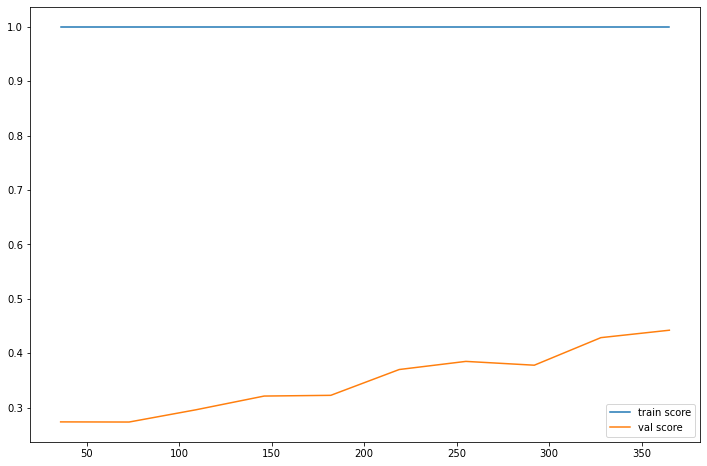

In [91]:
df_4 = data.copy()
df_4 = df_4[key_columns + blood_columns + viral_columns]

model_4 = RandomForestClassifier(random_state=0)

df_4, X_train_4 = evaluation(model_4, df_4)

<AxesSubplot:>

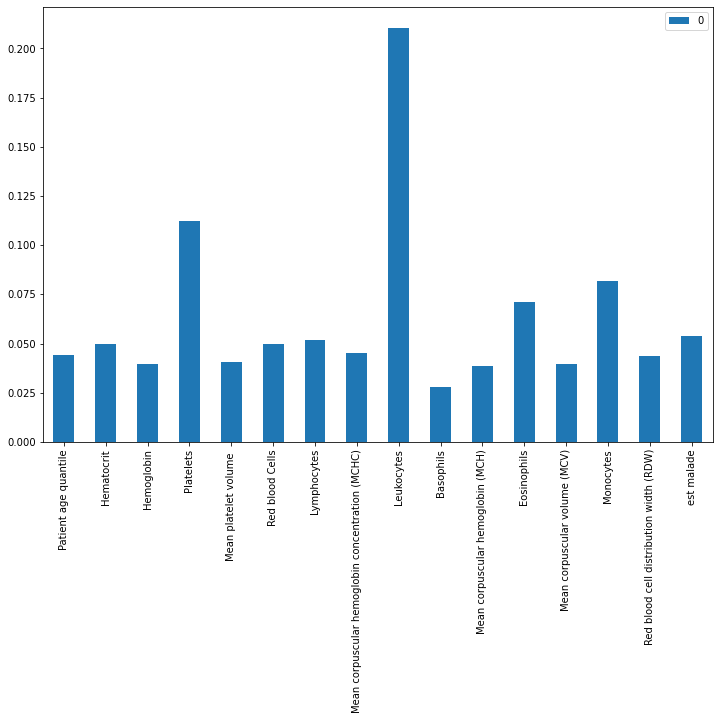

In [92]:
pd.DataFrame(model_4.feature_importances_, index=X_train_4.columns).plot.bar(figsize=(12, 8))

## SelectKbest et pipeline

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[92  3]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111



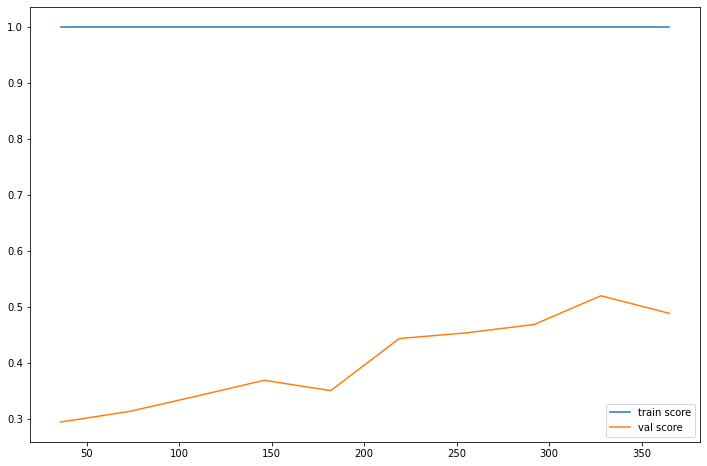

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

df_5 = data.copy()
df_5 = df_5[key_columns + blood_columns + viral_columns]

model_5 = make_pipeline(SelectKBest(f_classif, k=10),
                        RandomForestClassifier(random_state=0))

df_5, X_train_5 = evaluation(model_5, df_5)

## `PolynomialFeatures`

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings

/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings

/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/dorian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


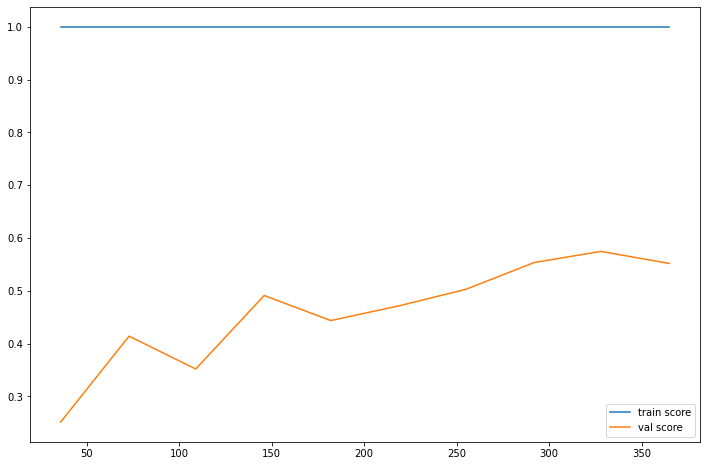

In [94]:
from sklearn.preprocessing import PolynomialFeatures

df_6 = data.copy()
df_6 = df_5[key_columns + blood_columns + viral_columns]

model_6 = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=10),
                      RandomForestClassifier(random_state=0))

df_6, X_train_6 = evaluation(model_6, df_6)

<AxesSubplot:>

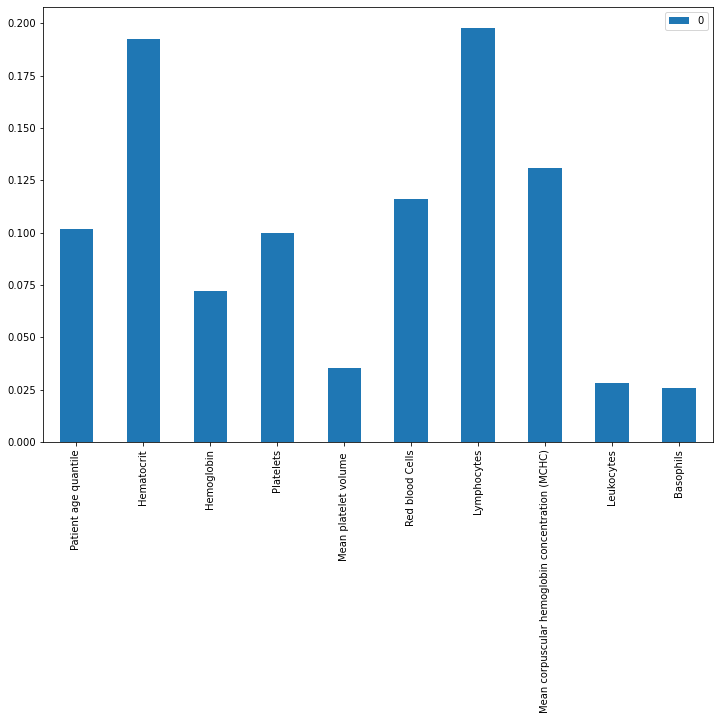

In [104]:
pipeline_model = model_6.steps[2][1]
pd.DataFrame(pipeline_model.feature_importances_, index=X_train_6.columns[:10]).plot.bar(figsize=(12, 8))